# Quantum Game Theory - Multiple Maze Pathway Solving

A maze-solving algorithm is an automated method for solving a maze. The random mouse, wall follower, Pledge, and Trémaux's algorithms are designed to be used inside the maze by a traveler with no prior knowledge of the maze, whereas the dead-end filling and shortest path algorithms are designed to be used by a person or computer program that can see the whole maze at once.

This example is showing the potential of Dynex parallel processing.

Coded by Y3TI & Sam Rahmeh

In [1]:
import time
import numpy as np
import random
import dimod
import dynex
import matplotlib.pyplot as plt
import networkx as nx
import re
from collections import deque
import multiprocessing
from queue import Empty

In [2]:
def generateMaze(dim):
    maze = np.ones((dim * 2 + 1, dim * 2 + 1))
    stack = [(0, 0)]
    while stack:
        x, y = stack.pop()
        directions = [(dx, dy) for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]]
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < dim and 0 <= ny < dim and maze[2 * nx + 1, 2 * ny + 1] == 1:
                maze[2 * nx + 1, 2 * ny + 1] = 0
                maze[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                stack.append((nx, ny))
    maze[1, 0] = 0
    maze[-2, -1] = 0
    return maze

def buildBQM(maze):
    rows, cols = maze.shape
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    pathIncentive = -1000
    connectivityReward = 200
    directionalBiasFactor = 0.1
    extraPenaltyForTurns = -50
    exitPoint = (rows - 2, cols - 1)
    for rowIndex in range(rows):
        for columnIndex in range(cols):
            if maze[rowIndex, columnIndex] != 1:
                distanceToExit = abs(exitPoint[0] - rowIndex) + abs(exitPoint[1] - columnIndex)
                directionalIncentive = pathIncentive - directionalBiasFactor * distanceToExit
                bqm.add_variable((rowIndex, columnIndex), directionalIncentive)
    for rowIndex in range(rows):
        for columnIndex in range(cols):
            if (rowIndex, columnIndex) in bqm.linear:
                if rowIndex > 0 and (rowIndex - 1, columnIndex) in bqm.linear:
                    verticalBias = connectivityReward
                    if rowIndex > exitPoint[0]:
                        verticalBias /= 2
                    bqm.add_interaction((rowIndex, columnIndex), (rowIndex - 1, columnIndex), verticalBias)
                if columnIndex > 0 and (rowIndex, columnIndex - 1) in bqm.linear:
                    horizontalBias = connectivityReward
                    if columnIndex > exitPoint[1]:
                        horizontalBias /= 2
                    bqm.add_interaction((rowIndex, columnIndex), (rowIndex, columnIndex - 1), horizontalBias)
                if rowIndex > 0 and columnIndex > 0 and (rowIndex - 1, columnIndex - 1) in bqm.linear:
                    diagonalInteractionPenalty = extraPenaltyForTurns
                    bqm.add_interaction((rowIndex, columnIndex), (rowIndex - 1, columnIndex - 1), diagonalInteractionPenalty)
                if rowIndex < rows - 1 and columnIndex < cols - 1 and (rowIndex + 1, columnIndex + 1) in bqm.linear:
                    if rowIndex < exitPoint[0] and columnIndex < exitPoint[1]:
                        diagonalInteractionReward = connectivityReward / 3
                        bqm.add_interaction((rowIndex, columnIndex), (rowIndex + 1, columnIndex + 1), diagonalInteractionReward)
    return bqm

def bfsAlgorithm(start, goal, graph):
    queue = deque([start])
    path = {start: None}
    while queue:
        current = queue.popleft()
        if current == goal:
            break
        for neighbor in graph[current]:
            if neighbor not in path:  
                queue.append(neighbor)
                path[neighbor] = current  
    if goal in path:
        step = goal
        path_sequence = []
        while step is not None:
            path_sequence.append(step)
            step = path.get(step)
        return path_sequence[::-1]  
    else:
        return None 

def visualizeSolution(maze, solution=None, ax=None, title=""):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=10)  # Add title to each subplot
    if solution is not None:
        graph = {}
        path_nodes = [node for node, active in solution.items() if active == 1]
        for node in path_nodes:
            graph[node] = []
            neighbors = [(node[0] + dx, node[1] + dy) for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]]
            for neighbor in neighbors:
                if neighbor in path_nodes:
                    graph[node].append(neighbor)
        start_point = (1, 0)
        exit_point = (maze.shape[0]-2, maze.shape[1]-1)
        path = bfsAlgorithm(start_point, exit_point, graph)
        if path:
            x_data = [p[1] for p in path]
            y_data = [p[0] for p in path]
            ax.plot(x_data, y_data, color='red', linewidth=2)
        else:
            print("[DYNEX] NO PATHWAY FOUND\n")

def processMaze(size):
    maze = generateMaze(size)
    return maze

def plotMazes(results):
    num_mazes = len(results)
    cols = 3
    rows = (num_mazes + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))  # Adjusted figure size and layout
    axes = axes.flatten()
    for i, maze in enumerate(results):
        if i < len(axes):  # To avoid index error if results are fewer than axes
            visualizeSolution(maze, None, ax=axes[i], title=f"MAZE SIZE - {maze.shape[0]//2}")
            axes[i].set_aspect('equal')  # Set aspect ratio to equal
    for i in range(len(results), len(axes)):  # Hide any unused subplots
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def plotSolvedMazes(results):
    num_mazes = len(results)
    cols = 3
    rows = (num_mazes + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))  # Adjusted figure size and layout
    axes = axes.flatten()
    for i, (maze, solution) in enumerate(results):
        if i < len(axes):  # To avoid index error if results are fewer than axes
            visualizeSolution(maze, solution, ax=axes[i], title=f"MAZE SIZE - {maze.shape[0]//2}")
            axes[i].set_aspect('equal')  # Set aspect ratio to equal
    for i in range(len(results), len(axes)):  # Hide any unused subplots
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def solveMazeParallel(maze, num_reads=2000, annealing_time=700):
    bqm = buildBQM(maze)
    model = dynex.BQM(bqm)
    sampler = dynex.DynexSampler(model, mainnet=True, description='Quantum Multi Maze Solver')
    start_time = time.time()
    sampleset = sampler.sample(num_reads=num_reads, annealing_time=annealing_time, debugging=False, alpha=10, beta=1)
    end_time = time.time()
    solve_time = end_time - start_time
    return sampleset, solve_time

def solveAndVisualizeMazesParallel(all_results, max_parallel_jobs=3):
    total_run_time = 0
    solutions = []

    with multiprocessing.Pool(processes=max_parallel_jobs) as pool:
        results = [pool.apply_async(solveMazeParallel, (maze,)) for maze in all_results]
        for r in results:
            sampleset, solve_time = r.get()
            solution = sampleset.first.sample
            solutions.append(solution)
            total_run_time += solve_time
    
    solved_mazes = list(zip(all_results, solutions))
    plotSolvedMazes(solved_mazes)
    print(f"\n[DYNEX] TOTAL TIME: {total_run_time:.2f} SECONDS")

In [3]:
# Sizes of the mazes to generate and solve
# Any Maze Size larger than 30 requires mainnet=True in the solveMazeParallel function
maze_sizes = [40, 50, 60, 70, 80, 90]
# Max Number of Parallel Jobs (Each job uses VRAM to compile the job for Dynex - 3 for 6GB / 4 for 8GB etc..)
parallel_jobs = 6

[DYNEX] ALL MAZES GENERATED...


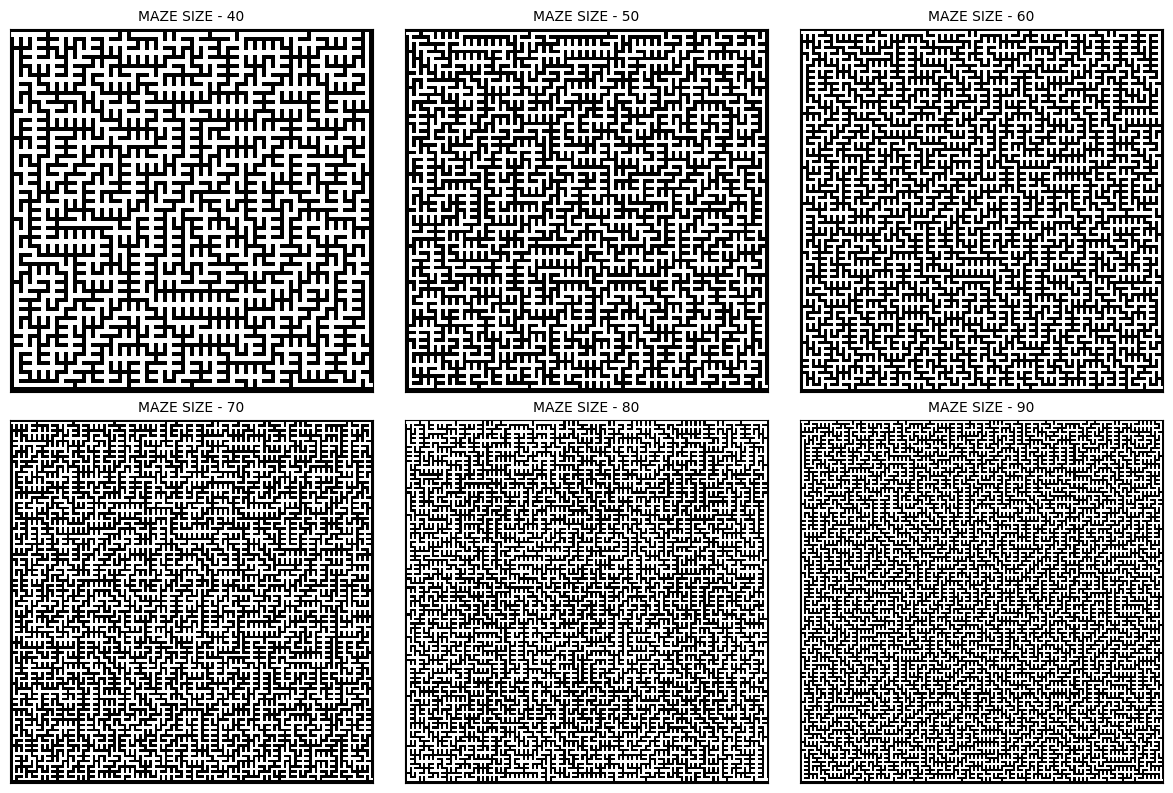

In [4]:
# Generate Unsolved Mazes ready for computation
all_results = []
for size in maze_sizes:
    result = processMaze(size)
    all_results.append(result)
    
print("[DYNEX] ALL MAZES GENERATED...")
plotMazes(all_results)

╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │   ELAPSED │   WORKERS READ │   CIRCUITS │   STEPS │   GROUND STATE │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼────────────────┼────────────┼─────────┼────────────────┤
│      23884 │    16209 │           36741 │       12.60 │      7.57 │              2 │       2080 │     700 │    33123444.00 │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴────────────────┴────────────┴─────────┴────────────────╯
╭────────────┬─────────────────┬────────────┬───────┬─────────────┬───────────────┬─────────────────────────────┬──────────────┬──────────╮
│     WORKER │         VERSION │   CIRCUITS │   LOC │      ENERGY │       RUNTIME │                 LAST UPDATE │        STEPS │   STATUS │
├────────────┼─────────────────┼────────────┼───────┼─────────────┼───────────────┼──

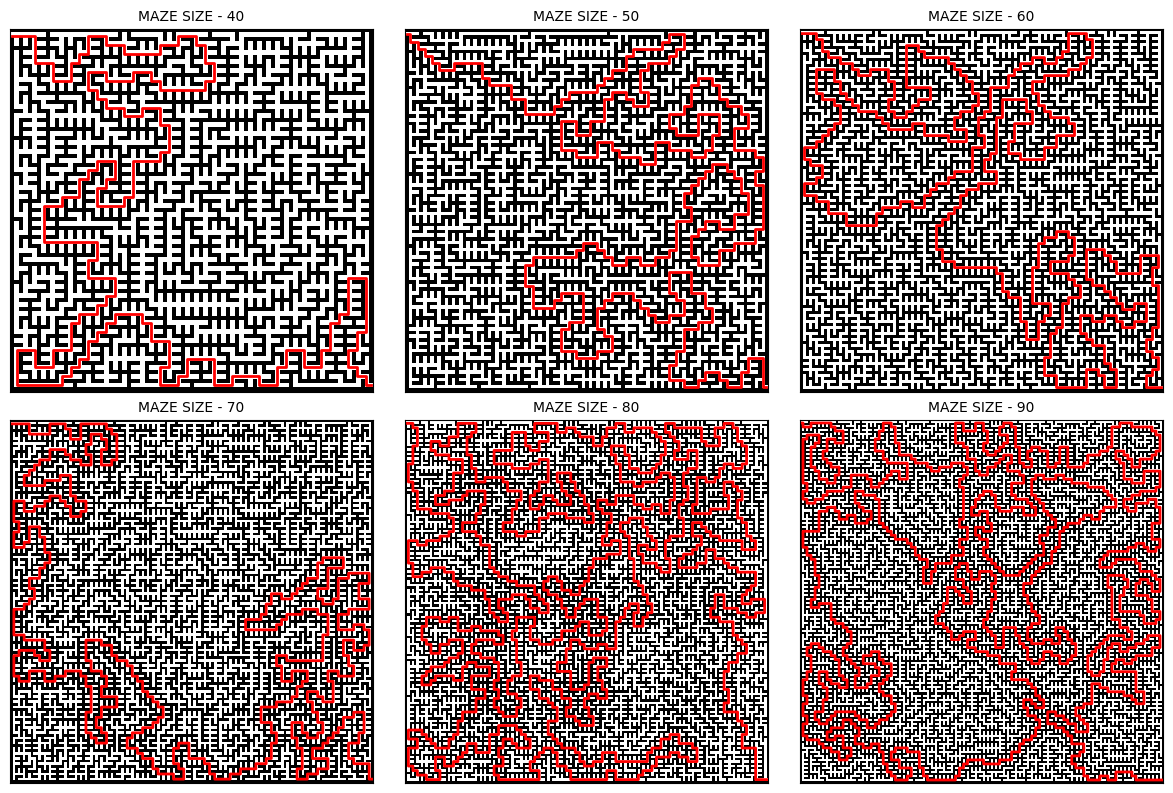


[DYNEX] TOTAL TIME: 676.18 SECONDS


In [5]:
# Generate Solved Mazes computed on Dynex
print("[DYNEX] SOLVING MAZES...")
solveAndVisualizeMazesParallel(all_results, max_parallel_jobs=parallel_jobs)